# Исследование алгоритмов кластеризации

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
def get_colors(labels):
    colors = []
    for l in labels:
        if l == 0:
            colors.append('red')
        elif l == 1:
            colors.append('blue')
        else:
            colors.append('green')
    return colors

Реализовать классификацию объектов 3х классов на основе алгоритма k-средних и агломеративной кластеризации. Выбрать метрику (функцию расстояния), минимизирующую ошибку классификации.

In [72]:
n = 2
M = 3
NN = 900

In [73]:
centers = [(-4, 3), (0, 0), (0, 4)]
X,y = make_blobs(n_samples=NN,n_features=n,centers=centers,cluster_std=1.0,random_state=17)

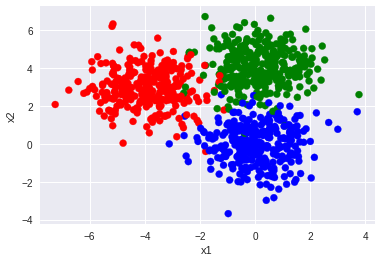

In [74]:
plt.scatter(X[:,0],X[:,1],c = get_colors(y))
plt.xlabel('x1')
plt.ylabel('x2');

## Алгоритм k-средних

<table style="width:100%">
  <tr>
    <td><img src = 'img/124px-K_Means_Example_Step_1.svg.png'></td>
    <td>Начальные центроиды выбираются случайным образом </td>
  </tr>
  <tr>
    <td><img src = 'img/139px-K_Means_Example_Step_2.svg.png'></td>
    <td>Точки выборки относятся к начальным центроидам(изображено разбиение Вороного)</td>
  </tr>
  <tr>
    <td><img src = 'img/139px-K_Means_Example_Step_3.svg.png'></td>
    <td>Пересчет центроид</td>
  </tr>
  <tr>
    <td><img src = 'img/139px-K_Means_Example_Step_4.svg.png'></td>
    <td>Повторение предыдущих шагов до схождения алгоритма</td>
  </tr>
</table>

Алгоритм k-средних итеративно минимизирует среднее внутрикластерное расстояние:
1. Объект присваивается к кластеру, центр которого ближе.
2. Центр кластера перемещается в среднее арифметическое векторов признаков объектов кластера.

$$J(C_k) = \sum_{y \in Y} \frac{1}{|C_y|} \sum_{y_i = y} \rho^2(x_i,\mu_i) \longrightarrow min, $$
где $C_y = \{x_i \in X^l | y_i = y\}$ - кластер с номером $y$.

$$$$

In [98]:
kmeans = KMeans(n_clusters=3,max_iter=100,tol=1e-6,random_state=17)#работает только с евклидовой метрикой

In [99]:
cluster_labels = kmeans.fit_predict(X) 

In [100]:
cluster_centers = kmeans.cluster_centers_

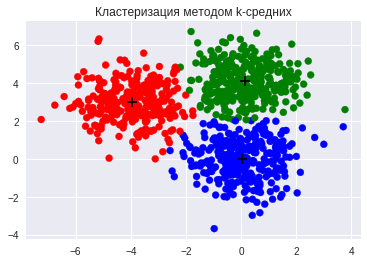

In [101]:
plt.scatter(X[:,0],X[:,1],c =get_colors(cluster_labels));
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='+',s = 100, c='k')
plt.title('Кластеризация методом k-средних');

Диаграмма Вороного:

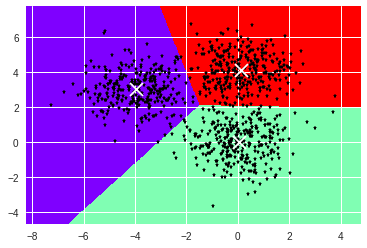

In [102]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02 

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.rainbow,
           aspect='auto', origin='lower')
plt.plot(X[:,0],X[:,1],'k*',markersize = 5 )
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x', s=169, linewidths=3,
            color='w', zorder=10);

In [103]:
print('Общий процент ошибок, допущенных при кластеризации = {0:.2f}%'.format(sum(cluster_labels!=y)/NN*100))

Общий процент ошибок, допущенных при кластеризации = 3.00%


Метод локтя: для каждого натурального k из некоторого диапазона строится значение целевой функции алгоритма $J(C_k)$. Количество классов определяется, как значение k, начиная с которой величина $J(C_k)$ падает не так резко.

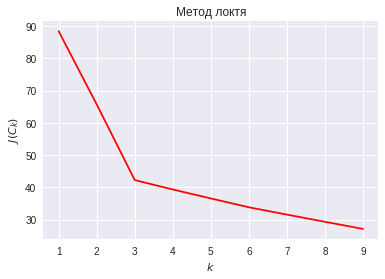

In [104]:
inertia = []# сумма расстояний от точек до ближайшего центра кластера
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k).fit(X)
    km.fit(X)
    inertia.append(np.sqrt(km.inertia_))

plt.plot(K, inertia, 'rx-')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.title('Метод локтя')
plt.show()

Судя по графику, $k = 3$ является оптимальным.

## Иерархическая кластеризация

- дивизимная
- агломеративная

### Агломеративная кластеризация

Cначала каждый объект является отдельным кластером. Затем запускается процесс слияний, и на каждой итерации два самых близких кластера $U$ и $V$ объединяются в один $W = U \cup V$. Расстояние от нового кластера до любого другого вычисляется по формуле Ланса-Уильямса:<br><p> $$R(U \cup V,S) = \alpha_U R(U,S) + \alpha_V R(V,S) + \beta R(U,V)
+ \gamma |R(U,S) - R(V,S)| $$</p>

Для вычисления расстояний мы будем использовать среднее расстояние(Unweighted average distance (UPGMA)).<br>

<p>$$R^с(W,S) = \frac{1}{|W||S|} \sum_{w \in W} \sum_{s \in S} \rho(w,s) $$</p>
<p>$$\alpha_U = \frac{|U|}{|W|}, \alpha_V = \frac{|V|}{|W|}, \beta = \gamma = 0$$</p>

In [109]:
metrics = ['euclidean','l1','manhattan']

In [110]:
for metric in metrics:
    agclust = AgglomerativeClustering(n_clusters=3,affinity=metric,linkage='average')
    cluster_labels = agclust.fit_predict(X)
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == 0:
            cluster_labels[i] = 1
            continue
        if cluster_labels[i] == 1:
            cluster_labels[i] = 0
    print('Метрика: {0}. Ошибка = {1:.2f}% '.format(metric,sum(cluster_labels!=y)/NN*100))     

Метрика: euclidean. Ошибка = 3.89% 
Метрика: l1. Ошибка = 3.33% 
Метрика: manhattan. Ошибка = 3.33% 


In [111]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    fig, ax = plt.subplots(figsize=(20, 15))
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, ax = ax,**kwargs)

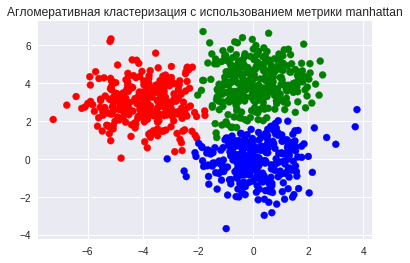

In [112]:
plt.scatter(X[:,0],X[:,1],c =get_colors(cluster_labels))
plt.title('Агломеративная кластеризация с использованием метрики manhattan');

Иерархические алгоритмы кластеризации(алгоритмы таксономии) строят не одно разбиение выборки на непересекающиеся классы, а _систему вложенных разбиений_. Результат таксономии обычно представляется в виде таксономического дерева — __дендрограммы__.

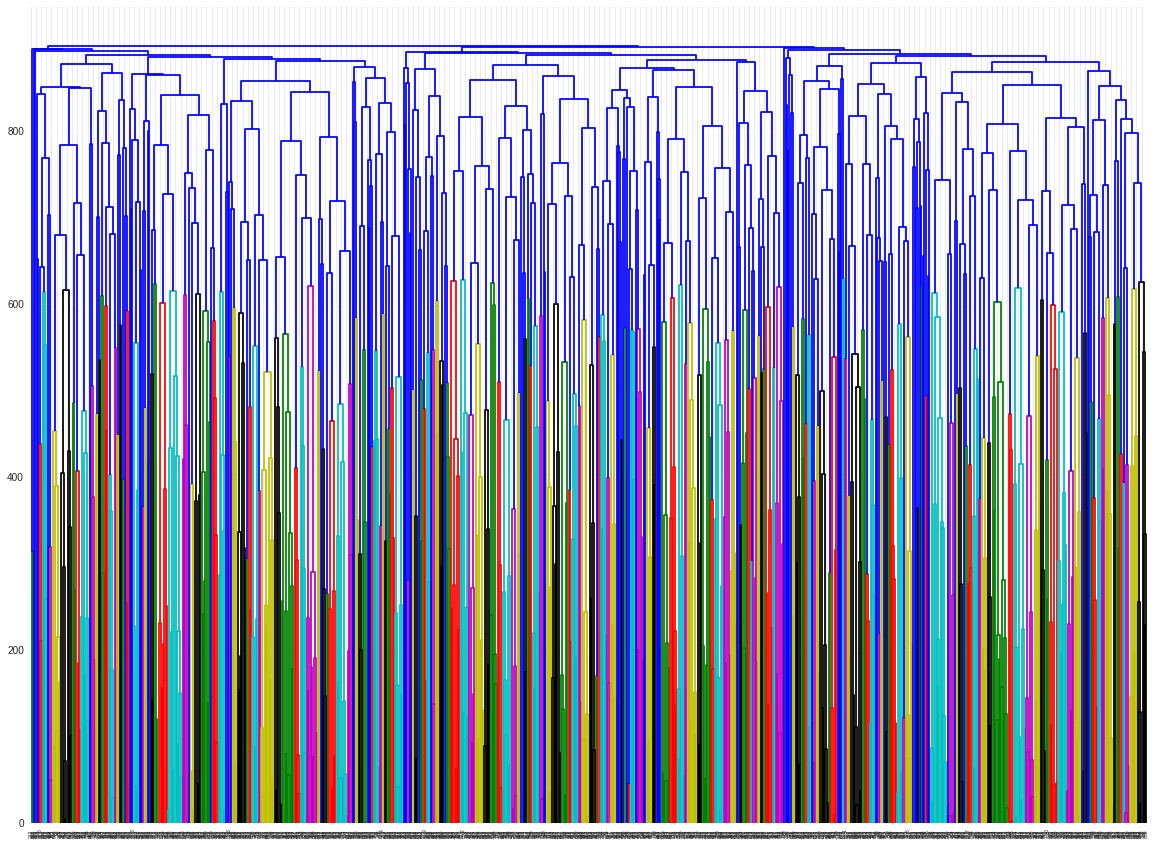

In [113]:
plot_dendrogram(agclust) 

***

Материалы:<br>
https://en.wikipedia.org/wiki/K-means_clustering <br>
https://www.coursera.org/learn/unsupervised-learning/lecture/9Z0EX/mietod-k-sriednikh-k-means <br>
http://www.machinelearning.ru/wiki/images/c/ca/Voron-ML-Clustering.pdf<br>
https://en.wikipedia.org/wiki/UPGMA